## $$\text{PyTorch}$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F

### Importando imagénes

In [4]:
from utils import get_images

# MNIST path
mnist_path = 'data/mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float64)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float64)
y_test = y_test_num.copy().reshape(10000, 1)

### Normalizando las imágenes

In [5]:
def normalise(x_mean, x_std, x_data):
    return (x_data-x_mean)/x_std

x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

### Mostrando imágenes

numero: 1


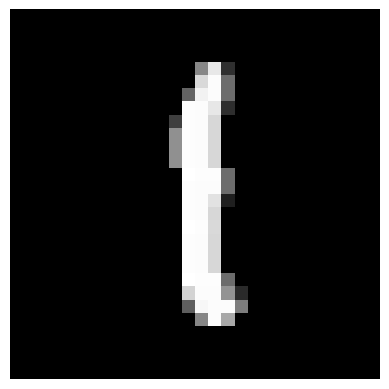

In [6]:
from utils import plot_number

rand_idx = np.random.randint(len(y_test_num))
print(f'numero: {y_test_num[rand_idx]}')
plot_number(x_test_num[rand_idx])

### Creando minibaches

In [27]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

### Convertimos los arreglos de Numpy as tensores de Pytorch

In [8]:
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

x_val_tensor = torch.Tensor(x_val.copy())
y_val_tensor = torch.Tensor(y_val.copy())

x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

### Usar GPU de estar disponible

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'estamos usando: {device}')

estamos usando: cpu


### Compute accuracy

In [34]:
def accuracy(model,x,y,mb_size):
    num_correct = 0
    num_total = 0
    model.eval() #poner el modelo en modo evaluación
    model = model.to(device=device) #cargando el modelo en gpu o cpu
    with torch.no_grad():
        for (xi,yi) in create_minibatches(x,y,mb_size):
            #cargamos las variables a la memoria del gpu o cpu
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi) #mb_size filas por 10 columnas (para este ejemplo)
            _,pred = scores.max(dim=1) 
            num_correct += (pred == yi.squeeze()).sum() #comprimimos yi ya que pred tiene la forma,shape, (mb_size,)
            num_total += pred.size(0) #se usa size ya que pred es un tensor, en caso de una arrglo se usa shape
        return float(num_correct)/num_total

### Loop de entrenamiento

In [32]:
def train(model,optimizer,mb_size,epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi,yi) in create_minibatches(x_train_tensor,y_train_tensor,mb_size):
            model.train() #cambiando a modo entrenamiento
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            #función costo
            cost = F.cross_entropy(input=scores,target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        print(f'epoch:{epoch} ,costo:{cost.item()} ,accuracy:{accuracy(model,x_val_tensor,y_val_tensor,mb_size)}')            

### Modelo usando Sequencial

In [30]:
#instanciar modelo
hidden1 = 200
hidden = 200
lr = 1e-4
epochs = 20
mb_size = 512

model1 = nn.Sequential(nn.Linear(in_features=784,out_features=hidden1),nn.ReLU(),
                        nn.Linear(in_features=hidden,out_features=10))

optimizer = torch.optim.SGD(model1.parameters(), lr=lr)

In [35]:
train(model1,optimizer,mb_size,epochs)

epoch:0 ,costo:2.3232476711273193 ,accuracy:0.104
epoch:1 ,costo:2.2773616313934326 ,accuracy:0.1115
epoch:2 ,costo:2.2446045875549316 ,accuracy:0.1205
epoch:3 ,costo:2.2635691165924072 ,accuracy:0.1313
epoch:4 ,costo:2.259185791015625 ,accuracy:0.1515
epoch:5 ,costo:2.224487781524658 ,accuracy:0.1714
epoch:6 ,costo:2.2183287143707275 ,accuracy:0.1979
epoch:7 ,costo:2.207873821258545 ,accuracy:0.2248
epoch:8 ,costo:2.1649234294891357 ,accuracy:0.262
epoch:9 ,costo:2.1727452278137207 ,accuracy:0.2936
epoch:10 ,costo:2.159405469894409 ,accuracy:0.3264
epoch:11 ,costo:2.1295855045318604 ,accuracy:0.3581
epoch:12 ,costo:2.106022357940674 ,accuracy:0.3912
epoch:13 ,costo:2.1139912605285645 ,accuracy:0.4225
epoch:14 ,costo:2.078920841217041 ,accuracy:0.4519
epoch:15 ,costo:2.0827581882476807 ,accuracy:0.482
epoch:16 ,costo:2.0555546283721924 ,accuracy:0.5083
epoch:17 ,costo:2.0384838581085205 ,accuracy:0.5318
epoch:18 ,costo:2.033234119415283 ,accuracy:0.5523
epoch:19 ,costo:2.00638175010681

In [36]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)

0.5591